<a href="https://colab.research.google.com/github/conextm/python/blob/main/Example_data_sintentica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load iris dataset
iris = datasets.load_iris()
X = iris.data  # Solo tomamos las primeras cuatro características.
y = iris.target

# Normalizar los datos
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Convertir los datos a un DataFrame de pandas
real_data = pd.DataFrame(X, columns=['a', 'b', 'c', 'd'])
real_labels = y

# Codificar one-hot las etiquetas
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_labels = one_hot_encoder.fit_transform(np.array(real_labels).reshape(-1, 1))

# Definir constantes
NOISE_DIM = 100 # espacio latente
NUM_CLASSES = 3
NUM_FEATURES = 4
BATCH_SIZE = 64
TRAINING_STEPS = 5000

# Generador
def create_generator():
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([noise_input, class_input])  # Concatenar el ruido y la clase
    hidden = Dense(128, activation='relu')(merged_input)    # Capa oculta con activación ReLU
    output = Dense(NUM_FEATURES, activation='linear')(hidden)  # Capa de salida lineal
    model = Model(inputs=[noise_input, class_input], outputs=output)
    return model

# Discriminador
def create_discriminator():
    data_input = Input(shape=(NUM_FEATURES,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([data_input, class_input])  # Concatenar los datos y la clase
    hidden = Dense(128, activation='relu')(merged_input)    # Capa oculta con activación ReLU
    output = Dense(1, activation='sigmoid')(hidden)         # Capa de salida con activación sigmoide
    model = Model(inputs=[data_input, class_input], outputs=output)
    return model

# cGAN
def create_cgan(generator, discriminator):
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    generated_data = generator([noise_input, class_input])  # Generar datos usando el generador
    validity = discriminator([generated_data, class_input])  # Pasar los datos generados al discriminador
    model = Model(inputs=[noise_input, class_input], outputs=validity)
    return model

# Crear y compilar el Discriminador
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

# Crear el Generador
generator = create_generator()

# Crear el cGAN
gan = create_cgan(generator, discriminator)

# Asegurar que solo el generador se entrene
discriminator.trainable = False

# Compilar el cGAN
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Entrenar el cGAN
for step in range(TRAINING_STEPS):
    # Seleccionar un lote aleatorio de datos reales con etiquetas
    idx = np.random.randint(0, real_data.shape[0], BATCH_SIZE)
    real_batch = real_data.iloc[idx].values
    labels_batch = one_hot_labels[idx]

    # Generar un lote de nuevos datos
    noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
    generated_batch = generator.predict([noise, labels_batch])

    # Entrenar el discriminador
    real_loss = discriminator.train_on_batch([real_batch, labels_batch], np.ones((BATCH_SIZE, 1)))
    fake_loss = discriminator.train_on_batch([generated_batch, labels_batch], np.zeros((BATCH_SIZE, 1)))
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Entrenar el generador
    generator_loss = gan.train_on_batch([noise, labels_batch], np.ones((BATCH_SIZE, 1)))

    if step % 500 == 0:
        print(f"Step: {step}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")

# Generar instancias para una clase dada
def generate_data(generator, data_class, num_instances):
    one_hot_class = one_hot_encoder.transform(np.array([[data_class]]))
    noise = np.random.normal(0, 1, (num_instances, NOISE_DIM))
    generated_data = generator.predict([noise, np.repeat(one_hot_class, num_instances, axis=0)])
    return pd.DataFrame(generated_data, columns=['a', 'b', 'c', 'd'])

# Generar 40 instancias de la clase 1
generated_data = generate_data(generator, 1, 40)
print(generated_data)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Se han truncado las últimas 5000 líneas del flujo de salida.
2/2 [==============================] - 0s 4ms/step
Step: 500, Discriminator Loss: 0.6781387627124786, Generator Loss: 0.7097131609916687
2/2 [==============================] - 0s 7ms/step
Step: 1000, Discriminator Loss: 0.6907999217510223, Generator Loss: 0.7091203927993774
2/2 [==============================] - 0s 9ms/step
Step: 1500, Discriminator Loss: 0.692859947681427, Generator Loss: 0.7037417888641357
2/2 [==============================] - 0s 5ms/step
Step: 2000, Discriminator Loss: 0.6957312524318695, Generator Loss: 0.6969871520996094
2/2 [==============================] - 0s 4ms/step
Step: 2500, Discriminator Loss: 0.6959767937660217, Generator Loss: 0.7081902027130127
2/2 [==============================] - 0s 3ms/step
Step: 3000, Discriminator Loss: 0.696431577205658, Generator Loss: 0.69556725025177
2/2 [==============================] - 0s 5ms/step
Step: 3500, Discriminator Loss: 0.6981380581855774, Generator Los

In [2]:
print("Generador:")
generator.summary()

print("\nDiscriminador:")
discriminator.summary()

print("\ncGAN:")
gan.summary()

Generador:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 103)                  0         ['input_3[0][0]',             
 )                                                                   'input_4[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 128)                  13312     ['concatenate

In [3]:
# Generate 50 instances for each class
synthetic_data_class_0 = generate_data(generator, 0, 50)
synthetic_data_class_1 = generate_data(generator, 1, 50)
synthetic_data_class_2 = generate_data(generator, 2, 50)

# Combine all synthetic data into a single DataFrame and apply inverse transform to bring it back to original scale
synthetic_data = pd.concat([synthetic_data_class_0, synthetic_data_class_1, synthetic_data_class_2], ignore_index=True)
synthetic_data = pd.DataFrame(scaler.inverse_transform(synthetic_data), columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'])

# Create corresponding class labels
synthetic_labels = [0]*50 + [1]*50 + [2]*50

# Add labels to the synthetic data
synthetic_data['class'] = synthetic_labels

# Save synthetic data as a CSV file
synthetic_data.to_csv('synthetic_iris_data.csv', index=False)

2/2 [==============================] - 0s 5ms/step


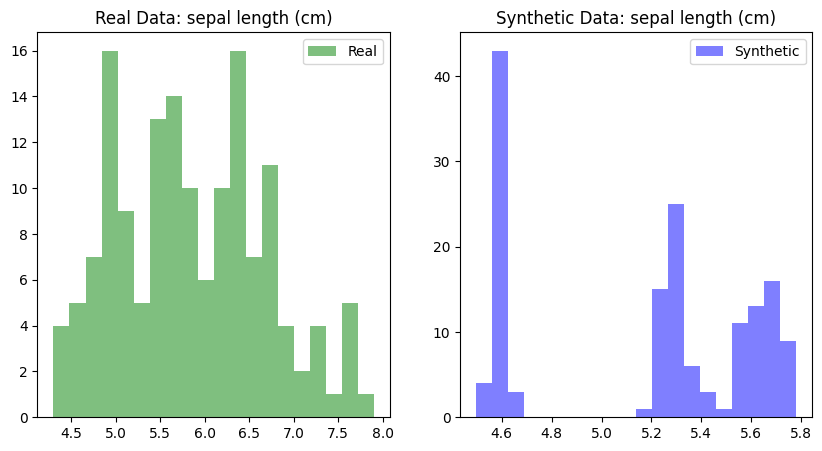

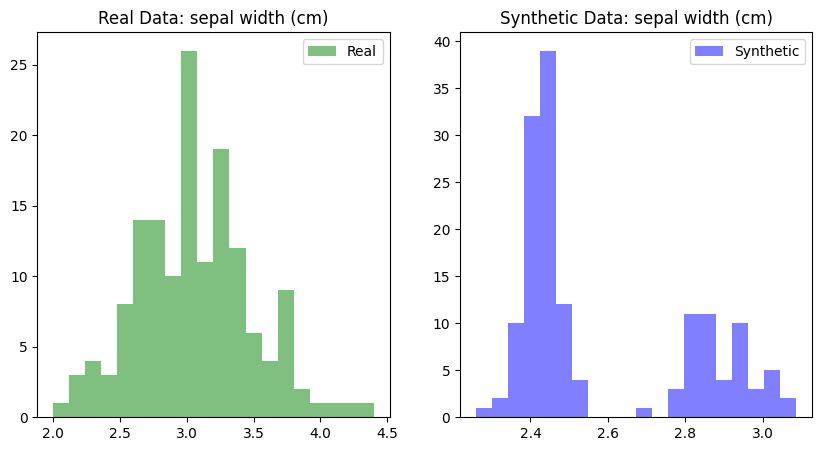

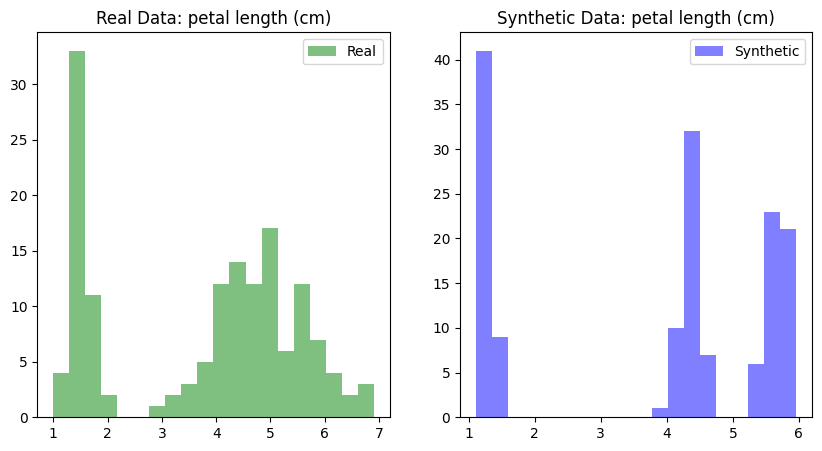

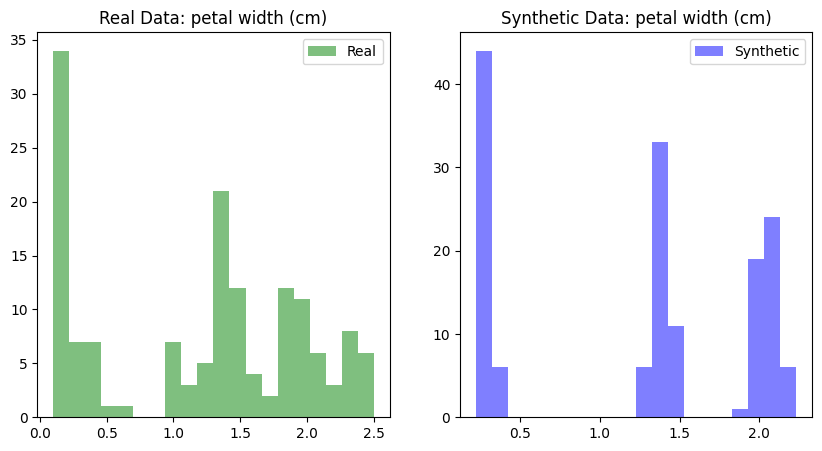

Summary statistics for the real data:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)       class  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  

Summary statistics for the synthe

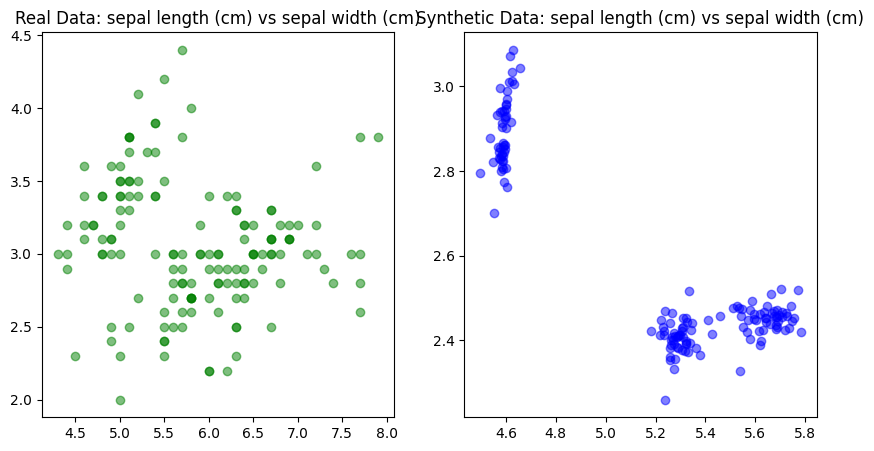

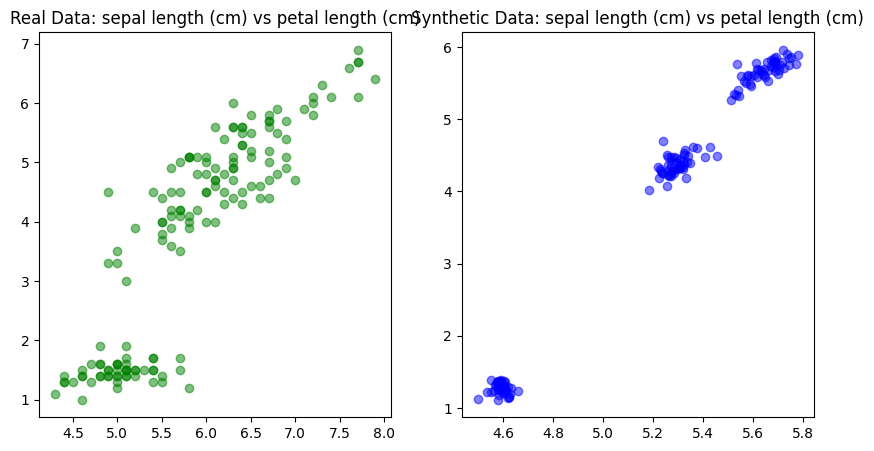

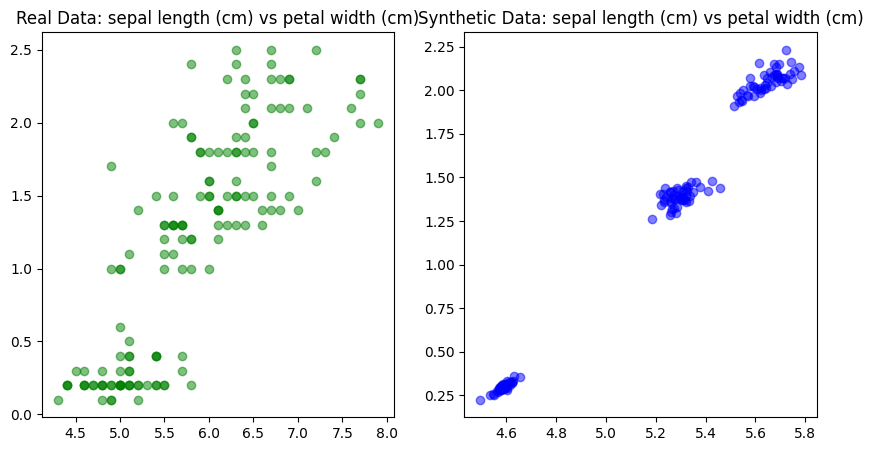

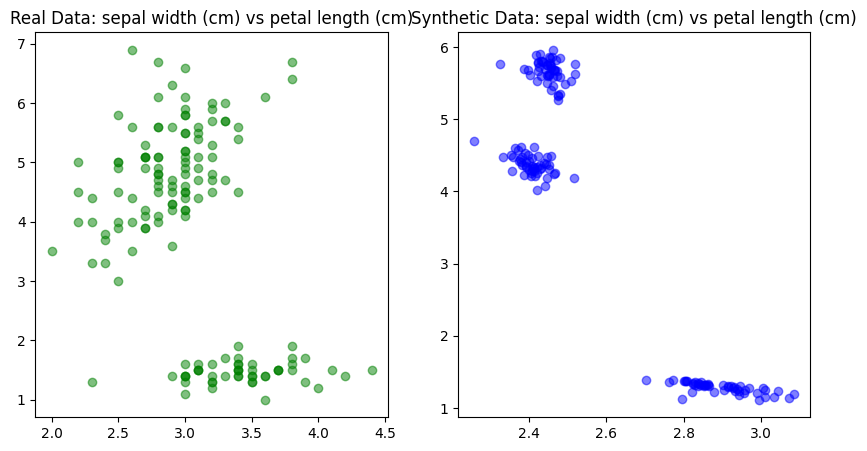

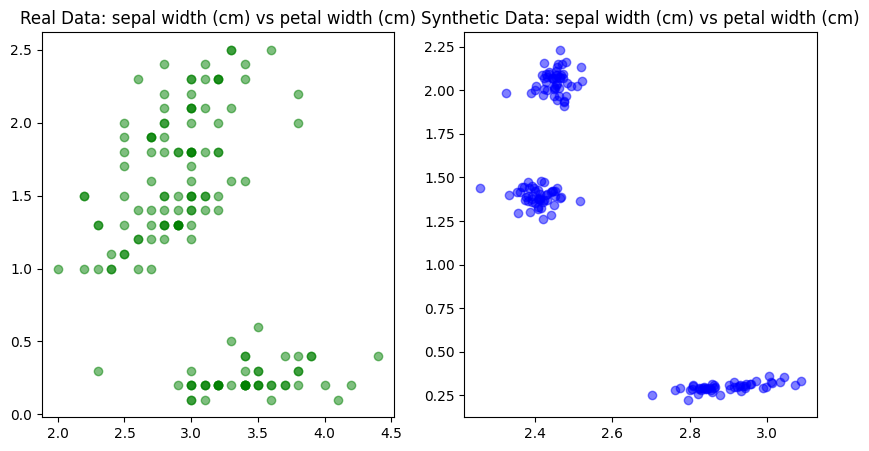

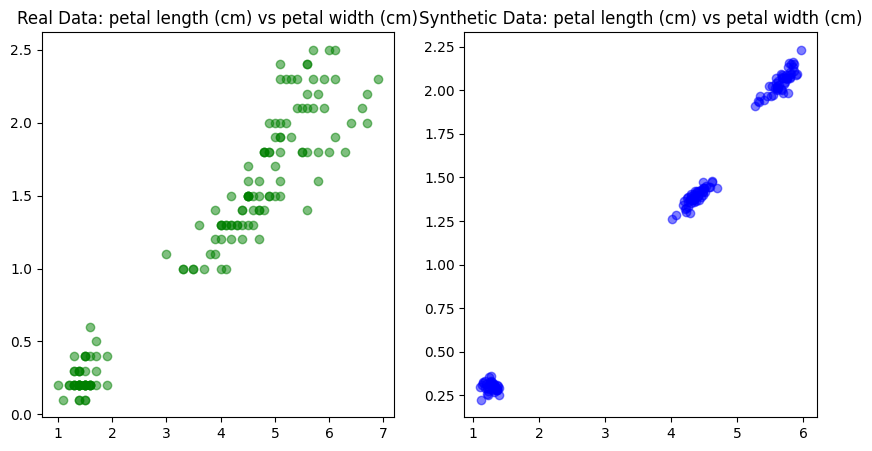

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

# Load the Iris dataset from sklearn
iris = datasets.load_iris()
real_data = pd.DataFrame(iris.data, columns=iris.feature_names)
real_data['class'] = iris.target

# Load the synthetic dataset
synthetic_data = pd.read_csv('synthetic_iris_data.csv')

# For each feature, create a histogram for the real and synthetic data
for feature in ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.hist(real_data[feature], bins=20, alpha=0.5, color='g', label='Real')
    plt.title(f"Real Data: {feature}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(synthetic_data[feature], bins=20, alpha=0.5, color='b', label='Synthetic')
    plt.title(f"Synthetic Data: {feature}")
    plt.legend()

    plt.show()

# Print the summary statistics for the real and synthetic data
print("Summary statistics for the real data:")
print(real_data.describe())
print("\nSummary statistics for the synthetic data:")
print(synthetic_data.describe())

# For each pair of features, create a scatter plot for the real and synthetic data
features = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
for i in range(len(features)):
    for j in range(i+1, len(features)):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(real_data[features[i]], real_data[features[j]], alpha=0.5, color='g')
        plt.title(f"Real Data: {features[i]} vs {features[j]}")

        plt.subplot(1, 2, 2)
        plt.scatter(synthetic_data[features[i]], synthetic_data[features[j]], alpha=0.5, color='b')
        plt.title(f"Synthetic Data: {features[i]} vs {features[j]}")

        plt.show()